In [119]:
import pandas as pd
import pyarrow
from dotenv import load_dotenv
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

load_dotenv()

file_path = os.getenv('FILE_PATH')

df_sample = pd.read_parquet(file_path + "detailed_woning_type_sample.parquet")
df = pd.read_csv(file_path + "bag_image_summary.csv", dtype="string")
df_joined = pd.merge(df_sample, df, how="left", right_on="bag_id", left_on="bag_nummeraanduidingid")
df_sample_with_urls = df_joined[df_joined["frontview_exists"].notna()]

# If you want to add the file path to the URLs, set this to True
add_file_path_to_urls = False

# Currently a funda sourced Url goes from: 
# frontview/0797/2000/0002/3888/0797200000023888.jpg
# to: img_dataset/07/079720000002-funda.jpg
def extract_path(url, source):
    if pd.isna(url) or url == '' or url is None:
        return ''
    id = url.rstrip('/').split('/')[-1]
    id, *_ = id.split('.')
    m = re.match(r'(\d{2})', id)
    first_two_digits = m.group(1) if m else ''
    return f"img_dataset/{first_two_digits}/{id}-{source}.jpg"

link_cols = ['frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url']
link_sources = ['funda', 'google', 'funda-in-business'] # Sources are in file name, so need to be added to filename for correct name

for col, source in zip(link_cols, link_sources):
    df_sample_with_urls[f'{col}_split'] = df_sample_with_urls[col].map(lambda url: extract_path(url, source))

# If you want to add the file path to the URLs, set add_file_path_to_urls to True
if add_file_path_to_urls:
    df_sample_with_urls[[f'{col}_split' for col in link_cols]] = df_sample_with_urls[[f'{col}_split' for col in link_cols]].map(lambda x: file_path + x if x else '')
    add_file_path_to_urls = False

df_sample_with_urls.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)

df = pd.read_csv(file_path + "Full_preprocessed_detailed_house.csv", dtype="string")

# Verschillend is a special case, so we remove it from the dataset
df = df[df['build_type'] != 'Verschillend']

def pick_first_url(row):
    for col in [f"{c}_split" for c in link_cols]:
        val = row[col]
        if pd.notna(val) and val != '':
            return val
    return ''

df['frontview_url'] = df.apply(pick_first_url, axis=1)
df = df[df['frontview_url'] != '']

# Ensure 'opp_pand' and 'oppervlakte' are numeric before division
df['procent_ingenomen'] = pd.to_numeric(df['opp_pand'], errors='coerce') / pd.to_numeric(df['oppervlakte'], errors='coerce')


df['huisnr_bag_letter'] = df['huisnr_bag_letter'].notna().astype(int)
df['huisnr_bag_toevoeging'] = df['huisnr_bag_toevoeging'].notna().astype(int)

df['is_monument'] = df['is_monument'].fillna(0).astype(int)
df['is_protected'] = df['is_protected'].fillna(0).astype(int)


df = df.drop(columns=['bag_nummeraanduidingid', 'frontview_exists', 'random_rank', 'num_funda_images',
                      'frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url', 
                      'frontview_funda_url_split', 'frontview_google_url_split', 'frontview_funda_in_business_url_split',
                      'special_house_type', 'source_data_result_id',
                      'straatnaam', 'postcode', 'plaatsnaam', 'source_data_timestamp', 'frontview_url', 'bag_id'
                      ])

# CURRENTLY DELETING GEOMETRY COLUMN, CHANGE IF NEEDED
df = df.drop(columns=['geometry'])

# Oversample corriderflat door random te dupliceren
df_majority = df[df['woningtype'] != 'Corridorflat']  
df_minority = df[df['woningtype'] == 'Corridorflat'] 

df_minority_oversampled = resample(
    df_minority,
    replace=True,                
    n_samples=500,               
    random_state=42            
)

# Voeg ze weer samen en shuffle, change random state for different shuffle
df_balanced = pd.concat([df_majority, df_minority_oversampled])
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Full preprocessed dataset with URLS, can be loaded into pipeline.
df.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)

# Normalizing and feature engineering are applied to the dataset separately for training, validation, and testing.
# This is to ensure that the model does not learn from the validation and test sets during training.

# adjust random_state for reproducibility
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Check if standardization is needed for huisnr and pocent_ingenomen, large numbers can be encoded as categorical?
for dataframe in [train_df, val_df, test_df]:
    for col in ['opp_pand', 'oppervlakte', 'build_year', 'huisnr']:
        scaler = StandardScaler()
        dataframe[col] = scaler.fit_transform(dataframe[[col]])

    if dataframe is train_df:
        build_type_train = train_df[['build_type']]
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoder.fit(build_type_train)
        raw_feature_names = encoder.get_feature_names_out(['build_type'])
        clean_feature_names = [name.replace(' ', '_') for name in raw_feature_names]

    build_type = dataframe[['build_type']]
    encoded_array = encoder.transform(build_type)
    encoded_df = pd.DataFrame(encoded_array, columns=clean_feature_names, index=dataframe.index)
    dataframe.drop('build_type', axis=1, inplace=True)
    dataframe[encoded_df.columns] = encoded_df

In [120]:
# Convert nullable float columns to standard float64
train_df["procent_ingenomen"] = train_df["procent_ingenomen"].astype("float64")
val_df["procent_ingenomen"] = val_df["procent_ingenomen"].astype("float64")
test_df["procent_ingenomen"] = test_df["procent_ingenomen"].astype("float64")


print(train_df.dtypes)


woningtype                                 string[python]
huisnr                                            float64
huisnr_bag_letter                                   int64
huisnr_bag_toevoeging                               int64
opp_pand                                          float64
oppervlakte                                       float64
build_year                                        float64
is_monument                                         int64
is_protected                                        int64
procent_ingenomen                                 float64
build_type_Appartement                            float64
build_type_Hoekwoning                             float64
build_type_Tussen_of_geschakelde_woning           float64
build_type_Tweeonder1kap                          float64
build_type_Vrijstaande_woning                     float64
dtype: object


In [121]:
import torch
from torch.utils.data import Dataset, DataLoader

# 1. Get sorted list of fine classes
fine_classes = sorted(train_df["woningtype"].unique())

# 2. Create class-to-index mapping
class_to_idx = {cls: i for i, cls in enumerate(fine_classes)}

# 3. Map labels to indices
train_df["label_idx"] = train_df["woningtype"].map(class_to_idx)
val_df["label_idx"] = val_df["woningtype"].map(class_to_idx)
test_df["label_idx"] = test_df["woningtype"].map(class_to_idx)

# Define feature columns (exclude target and index-like fields)
feature_cols = [col for col in train_df.columns if col not in ["woningtype", "label_idx"]]



class WoningDataset(Dataset):
    def __init__(self, df, feature_cols):
        self.X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df["label_idx"].values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

# Create datasets
train_dataset = WoningDataset(train_df, feature_cols)
val_dataset = WoningDataset(val_df, feature_cols)
test_dataset = WoningDataset(test_df, feature_cols)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


Epoch 1/30 | Train Loss: 2.3160
Epoch 2/30 | Train Loss: 1.7205
Epoch 3/30 | Train Loss: 1.6230
Epoch 4/30 | Train Loss: 1.5688
Epoch 5/30 | Train Loss: 1.5546
Epoch 6/30 | Train Loss: 1.5479
Epoch 7/30 | Train Loss: 1.5308
Epoch 8/30 | Train Loss: 1.5254
Epoch 9/30 | Train Loss: 1.5113
Epoch 10/30 | Train Loss: 1.5061
Epoch 11/30 | Train Loss: 1.4958
Epoch 12/30 | Train Loss: 1.4860
Epoch 13/30 | Train Loss: 1.4858
Epoch 14/30 | Train Loss: 1.4723
Epoch 15/30 | Train Loss: 1.4692
Epoch 16/30 | Train Loss: 1.4575
Epoch 17/30 | Train Loss: 1.4579
Epoch 18/30 | Train Loss: 1.4541
Epoch 19/30 | Train Loss: 1.4417
Epoch 20/30 | Train Loss: 1.4326
Epoch 21/30 | Train Loss: 1.4350
Epoch 22/30 | Train Loss: 1.4298
Epoch 23/30 | Train Loss: 1.4301
Epoch 24/30 | Train Loss: 1.4281
Epoch 25/30 | Train Loss: 1.4231
Epoch 26/30 | Train Loss: 1.4051
Epoch 27/30 | Train Loss: 1.4156
Epoch 28/30 | Train Loss: 1.4093
Epoch 29/30 | Train Loss: 1.4056
Epoch 30/30 | Train Loss: 1.3997


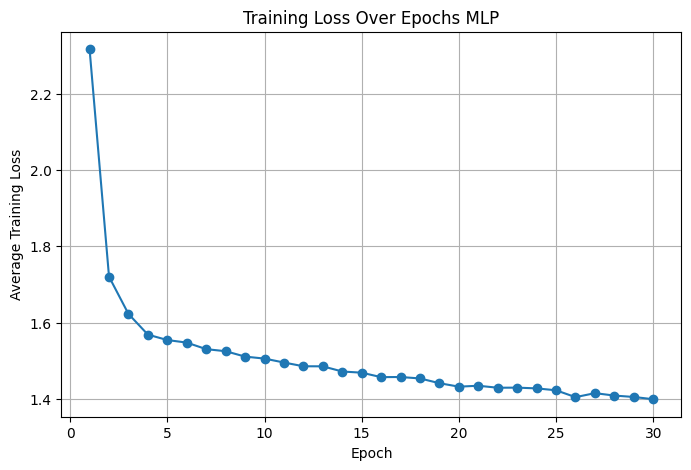

In [122]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report


# Assume your label column is called "woningtype"
fine_classes = sorted(df["woningtype"].unique())  # Get unique labels
NUM_FEATURES = len(feature_cols)


class_to_idx = {cls: i for i, cls in enumerate(fine_classes)}  # Map each class to an index
df["label_idx"] = df["woningtype"].map(class_to_idx)
idx_to_class = {i: c for c, i in class_to_idx.items()}


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.1):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU(), nn.Dropout(dropout)]
        layers += [nn.Linear(dims[-1], num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=NUM_FEATURES, hidden_dims=[256, 256, 128, 64], num_classes=15)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30  # or whatever you want

import matplotlib.pyplot as plt

# ... [rest of your code remains unchanged above] ...

loss_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)  # Store the average loss
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss Over Epochs MLP")
plt.grid(True)
plt.show()



In [123]:
import numpy as np
import torch
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, cohen_kappa_score, 
)

def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    kappa = cohen_kappa_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")




In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate on validation or test set, e.g.:
evaluate_model(model, val_loader, device, class_names=fine_classes)


Accuracy: 0.4759
Precision (macro): 0.4914
Recall (macro): 0.4764
F1 Score (macro): 0.4621
Cohen's Kappa: 0.4387
Log Loss: 1.4353


/home/rosa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


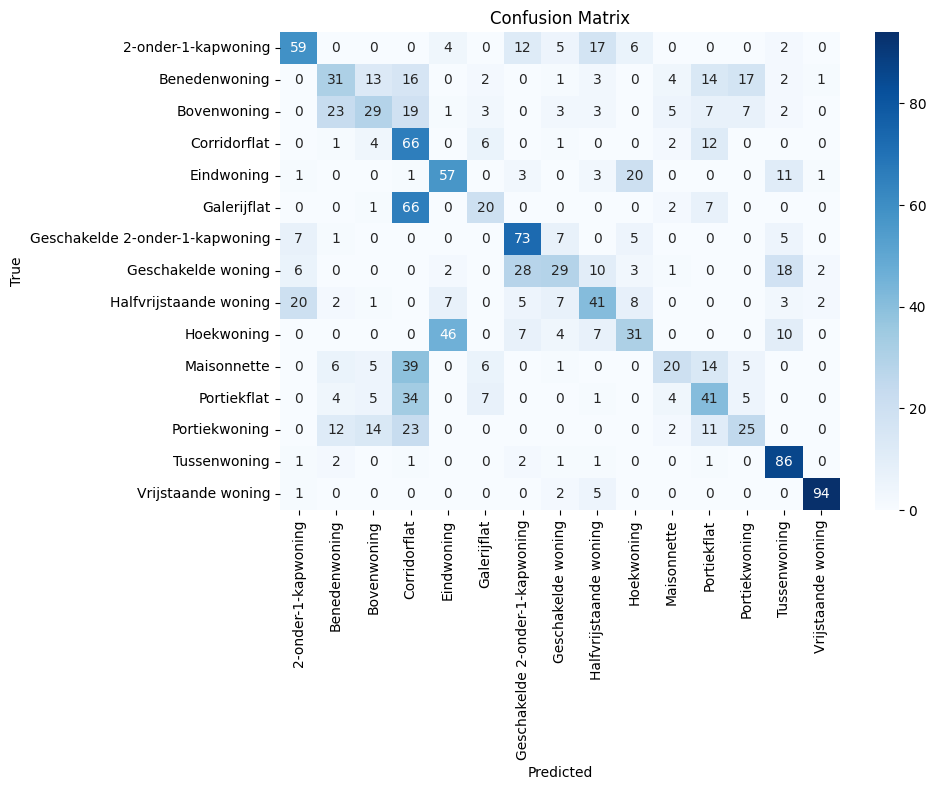

In [125]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, val_loader, class_names=fine_classes, device=device)
